In this project, we will use **Vision Transformer (ViT)** for the `Image Classification` task, **ViT** was introduced in [June 2021](https://arxiv.org/abs/2010.11929) by a team of researchers at Google Brain. 

This paper explored how you can `tokenize` images, just as you would tokenize sentences, so that they can be passed to transformer models for training.

1. Split an image into a grid of sub-image patches
2. Embed each patch with a linear projection
3. Each embedded patch becomes a token, and the resulting sequence of embedded patches is the sequence you pass to the model.

In this example post, we'll walk through how to leverage 🤗 datasets to download and process image classification datasets, and then use them to fine-tune a pre-trained ViT with 🤗 transformers.

We will also deploy the demo model on **Hugging Face Spaces** with **Gradio**.

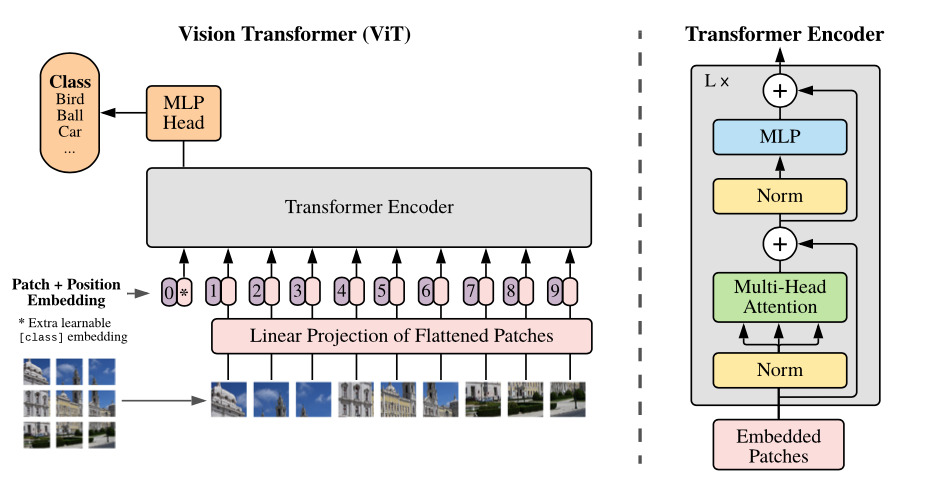

# Import modules

In [1]:
import os, glob
import torch
import math
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image, UnidentifiedImageError
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torchvision.datasets import ImageFolder
from transformers import ViTFeatureExtractor, ViTForImageClassification
from huggingface_hub import HfApi, HfFolder, Repository, notebook_login

# Load and split data

In [2]:
data_dir = Path('./data')

ds = ImageFolder(data_dir)
indices = torch.randperm(len(ds)).tolist()
n_val = math.floor(len(indices) * .10)
n_test = math.floor(len(indices) * .10)
train_ds = torch.utils.data.Subset(ds, indices[:-(n_val+n_test)])
val_ds = torch.utils.data.Subset(ds, indices[-(n_val+n_test):-n_test])
test_ds = torch.utils.data.Subset(ds, indices[-n_test:])
print("Train items:", len(train_ds), "Validation items:", len(val_ds), "Test items:", len(test_ds))

Train items: 20945 Validation items: 2617 Test items: 2617


# Visualize some examples

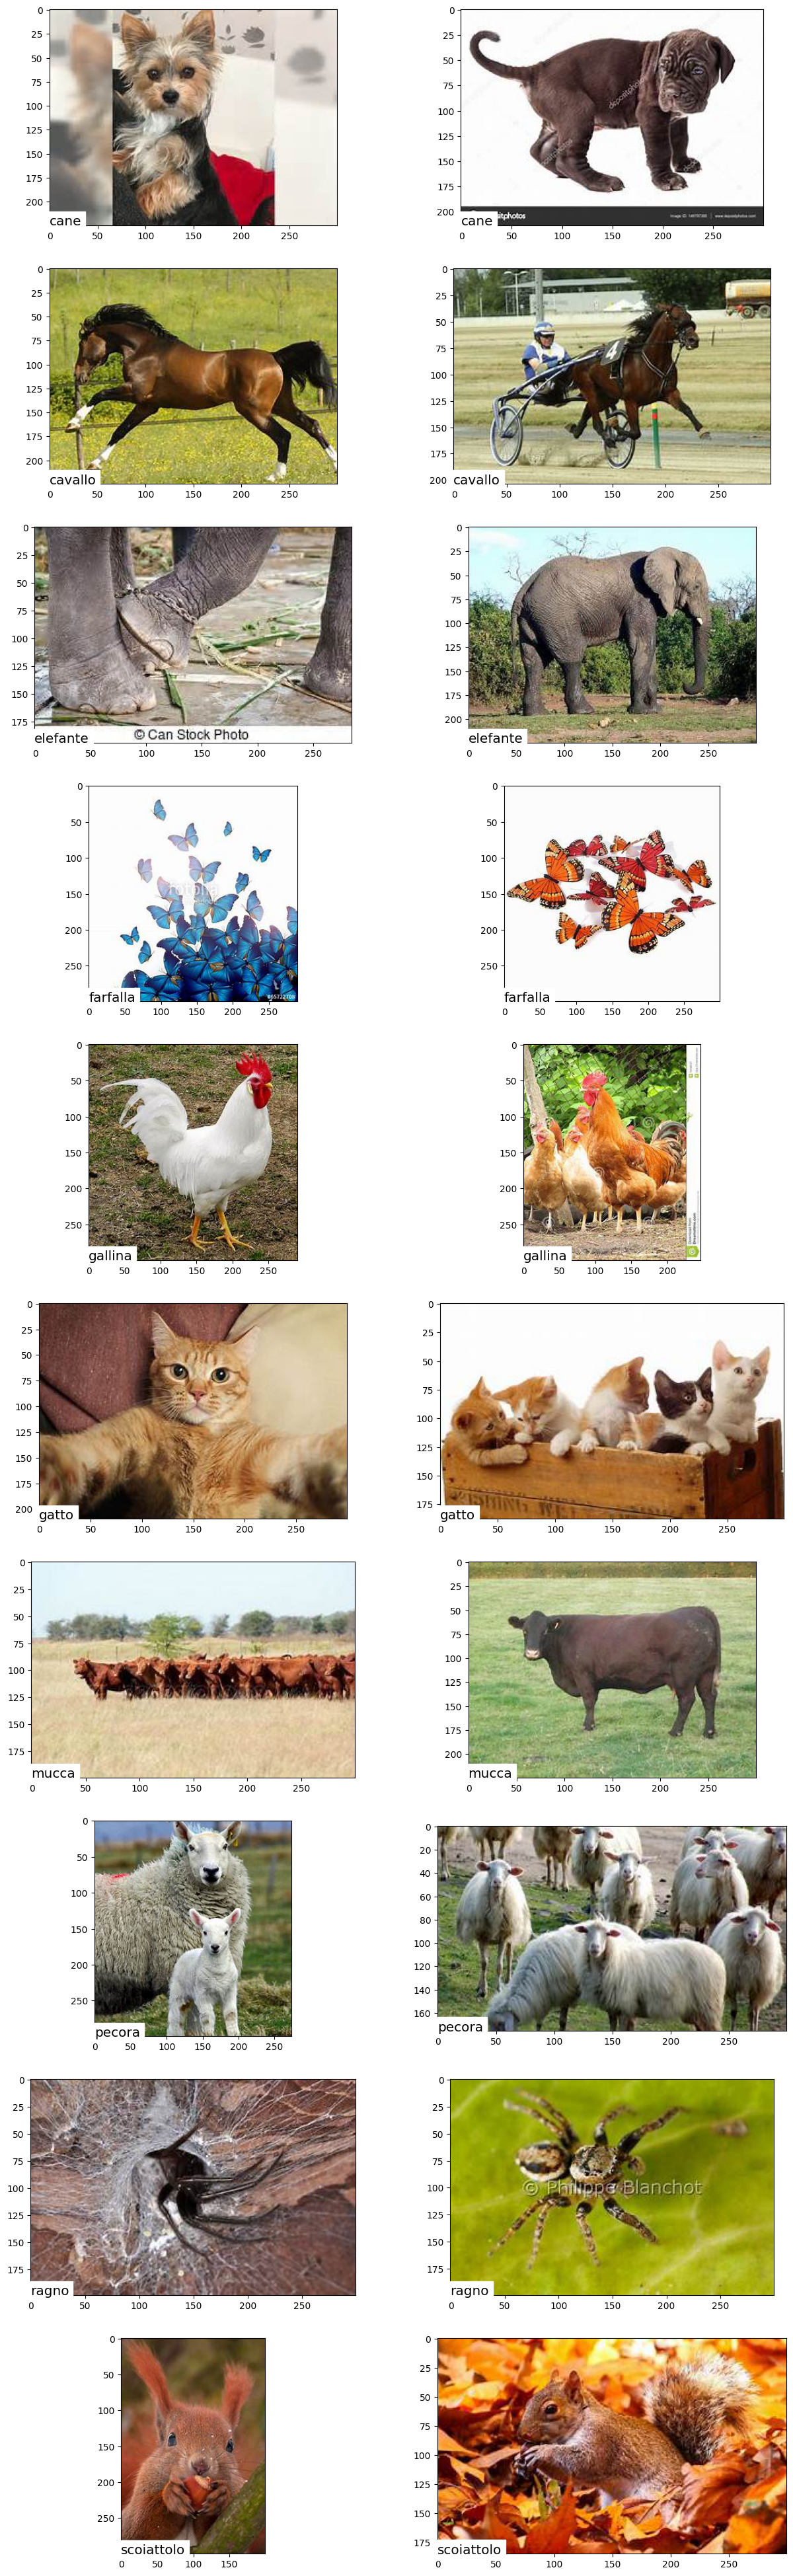

In [3]:
from pathlib import Path

plt.figure(figsize=(15,50))
num_examples_per_class = 2
i = 1
for class_idx, class_name in enumerate(ds.classes):
    folder = ds.root / class_name
    for image_idx, image_path in enumerate(sorted(folder.glob('*'))):
        if image_path.suffix in ds.extensions:
            image = Image.open(image_path)
            plt.subplot(len(ds.classes), num_examples_per_class, i)
            ax = plt.gca()
            ax.set_title(
            class_name,
            size='x-large',
            pad=0,
            loc='left',
            y=0,
            backgroundcolor='white'
            )
            ax.axis=('off')
            plt.imshow(image)
            i += 1
            
            if image_idx + 1 == num_examples_per_class:
                break

# Preparing labels for our model's config

By adding `label2id` + `id2label` to our model's config, we'll get friendlier labels in the inference API.

In [4]:
label2id = {}
id2label = {}

for i, class_name in enumerate(ds.classes):
    label2id[class_name] = str(i)
    id2label[str(i)] = class_name

print(label2id)
print(id2label)

{'cane': '0', 'cavallo': '1', 'elefante': '2', 'farfalla': '3', 'gallina': '4', 'gatto': '5', 'mucca': '6', 'pecora': '7', 'ragno': '8', 'scoiattolo': '9'}
{'0': 'cane', '1': 'cavallo', '2': 'elefante', '3': 'farfalla', '4': 'gallina', '5': 'gatto', '6': 'mucca', '7': 'pecora', '8': 'ragno', '9': 'scoiattolo'}


# Image classification collator

To apply our transforms to images, we'll use a custom collator class. We'll initialize it using an instance of `ViTFeatureExtractor` and pass the collator instance to `collate_fn` kwarg in `torch.utils.data.Dataloader`. Collator will prepare examples into batches which can then be unpacked into our model.

In [5]:
class ImageClassificationCollator:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor
        
    def __call__(self, batch):
        encodings = self.feature_extractor([x[0] for x in batch], return_tensors='pt')
        encodings['labels'] = torch.tensor([x[1] for x in batch], dtype=torch.long)
        return encodings

# Initialize feature extractor, model and data loaders

In [6]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
)
collator = ImageClassificationCollator(feature_extractor)
train_loader = DataLoader(train_ds, batch_size=8, collate_fn=collator, num_workers=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, collate_fn=collator, num_workers=2)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViT `feature extractor` takes the image as an input and transforms them into `16x16` patches with positional embeddings to make it suitable for feeding it into the model.

# Training

We will use **PyTorch Lightning** to fine-tune our model.

In [7]:
class Classifier(pl.LightningModule):
    
    def __init__(self, model, lr: float = 2e-5, **kwargs):
        super().__init__()
        self.save_hyperparameters('lr', *list(kwargs))
        self.model = model
        self.forward = self.model.forward
        self.val_acc = Accuracy()
        
    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log("train loss", outputs.loss)
        return outputs.loss
    
    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log("val loss", outputs.loss)
        acc = self.val_acc(outputs.logits.argmax(1), batch['labels'])
        self.log("val_acc", acc, prog_bar=True)
        return outputs.loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [8]:
pl.seed_everything(42)
classifier = Classifier(model, lr=2e-5)
trainer = pl.Trainer(gpus=1, precision=16, max_epochs=3)
trainer.fit(classifier, train_loader, val_loader)

Global seed set to 42
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                      | Params
------------------------------------------------------
0 | model   | ViTForImageClassification | 85.8 M
1 | val_acc | Accuracy                  | 0     
------------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
171.613   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/pytholic/anaconda3/envs/huggingface/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/pytholic/anaconda3/envs/huggingface/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# Load trained model directly

In [9]:
# path = 'lightning_logs/version_0/checkpoints/epoch=2-step=7857.ckpt'

In [10]:
# # Method 1
# checkpoint = torch.load(path)
# classifier = Classifier(model)
# classifier.load_state_dict(checkpoint['state_dict'])

In [11]:
# # Method 2
# Classifier.load_from_checkpoint(model, path)

In [12]:
# checkpoint = torch.load(path)
# print(checkpoint["hyper_parameters"])

# Check if it worked

In [17]:
model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_

In [18]:
val_batch = next(iter(val_loader))
outputs = model(**val_batch)
print("Pred: ", outputs.logits.softmax(1).argmax(1))
print("Labels: ", val_batch['labels'])

Pred:  tensor([2, 4, 8, 1, 3, 8, 8, 0])
Labels:  tensor([2, 4, 8, 1, 3, 8, 8, 0])


# Push to Hub
You will need to authenticate with your Hugging Face account.

You repo will be created at `{hf_username}/{model_id}`, so pick a mode_idl if that you like.

Use `notebook_login` to login with your hugging face account. Generate access token on hugging face and enter it.

In [19]:
notebook_login()

Login successful
Your token has been saved to /home/pytholic/.huggingface/token


In [20]:
import shutil

model_id = "vit_classification_huggingface"

description = """
Animal-10 dataset classification using Vision Transformer with Hugging Face.
"""

task_name = "Image Classification"
task_type = 'image-classification'
metric_name = 'Accuracy'
metric_type = 'accuracy'
metric_value = trainer.callback_metrics['val_acc'].item()

token = HfFolder().get_token()
if not token:
    raise RuntimeError("You must log in to push to hub! Run notebook_login() in the cell above.")
    
hf_username = HfApi().whoami()['name']
model_url = HfApi().create_repo(token=token, name=model_id, exist_ok=True)
model_repo = Repository("./model", clone_from=model_url, use_auth_token=token, git_email=f"{hf_username}@users.noreply.huggingface.co", git_user=hf_username)
model.save_pretrained(model_repo.local_dir)
feature_extractor.save_pretrained(model_repo.local_dir)

# Copy over tensorboard logs from lightning_logs/ into ./model/runs/
tensorboard_logs_path = next(Path(trainer.logger.log_dir).glob('events.out*'))
model_repo_logs_path = Path(model_repo.local_dir) / 'runs'
model_repo_logs_path.mkdir(exist_ok=True, parents=True)
shutil.copy(tensorboard_logs_path, model_repo_logs_path)

# Copy over a few example images
example_images_dir = Path(model_repo.local_dir) / 'data'
example_images_dir.mkdir(exist_ok=True, parents=True)
image_markdown_template = '''
#### {class_name}

![{class_name}](data/{example_image_path})
'''
example_images_markdown = ""
for class_idx, class_name in enumerate(ds.classes):
    folder = ds.root / class_name
    image_path = sorted(folder.glob('*'))[0]
    example_image_path = example_images_dir / f"{class_name.replace(' ', '_')}{image_path.suffix}"
    shutil.copy(image_path, example_image_path)
    example_images_markdown += image_markdown_template.format(
        class_name=class_name,
        example_image_path=example_image_path.name
    )
    
# Prepare README.md from information gathered above
readme_txt = f"""
---
tags:
- image-classification
- pytorch
- huggingpics
metrics:
- {metric_type}

model-index:
- name: {model_id}
  results:
  - task:
      name: {task_name}
      type: {task_type}
    metrics:
      - name: {metric_name}
        type: {metric_type}
        value: {metric_value}
---

# {model_id}

{description}

## Example Images

{example_images_markdown}

""".strip()

(Path(model_repo.local_dir) / 'README.md').write_text(readme_txt)

commit_url = model_repo.push_to_hub()

print("Check out your model at:")
print(f"https://huggingface.co/{hf_username}/{model_id}")

/home/pytholic/anaconda3/envs/huggingface/lib/python3.10/site-packages/huggingface_hub/hf_api.py:91: FutureWarning: `name` and `organization` input arguments are deprecated and will be removed in v0.10. Pass `repo_id` instead.
  warnings.warn(
/home/pytholic/Desktop/Personal/Projects/vit-classification-huggingface/./model is already a clone of https://huggingface.co/pytholic/vit_classification_huggingface. Make sure you pull the latest changes with `repo.git_pull()`.
Several commits (3) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 32.0k/327M [00:00<?, ?B/s]

Upload file runs/events.out.tfevents.1663910387.pytholic-pc.45959.0: 100%|##########| 15.0k/15.0k [00:00<?, ?B…

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/pytholic/vit_classification_huggingface
   c05c40b..cd1e4bd  main -> main



Check out your model at:
https://huggingface.co/pytholic/vit_classification_huggingface
